In [9]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import sklearn.svm
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import joblib
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as rmse
from sklearn.neural_network import MLPClassifier
import numpy as np
np.random.seed(0)

# Lectura de datos
- train.xlsx para entrenamiento
- val.xlsx para validacion

In [10]:
train = pd.read_csv("train.csv")
val = pd.read_csv("val.csv")


# Entrenamiento por mes


## Agrupacion de datos con:
- Mes
- Año
- Cluster

In [11]:
train_mes = train.groupby(['MES','ANIO','CLUSTER']).sum().reset_index()
train_mes = train_mes[['MES','ANIO','CLUSTER','atropello','caida_ocupante','choque','otro','volcamiento']]

val_mes = val.groupby(['MES','ANIO','CLUSTER']).sum().reset_index()
val_mes = val_mes[['MES','ANIO','CLUSTER','atropello','caida_ocupante','choque','otro','volcamiento']]


## Datos de entrenamiento 

In [12]:
#
X_train = train_mes[['MES','ANIO','CLUSTER']].values
y_train = train_mes[['atropello','caida_ocupante','choque','otro','volcamiento']].values


## Normalizacion
- Lo lleva a rango (0,1)

In [13]:
#StandardScaler()
#RobustScaler()
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler = min_max_scaler.fit(X_train)
X_train = min_max_scaler.transform(X_train)
joblib.dump(min_max_scaler,"scaler_mes.pkl")


['scaler_mes.pkl']

## Entrenamiento svm

In [14]:
svm =  MultiOutputRegressor(sklearn.svm.SVR(),n_jobs=-1)
scores = cross_val_score(svm, X_train, y_train, cv=5,scoring = 'neg_mean_squared_error')
print('R2 promedio:',np.mean(scores))
svm = svm.fit(X_train,y_train)
joblib.dump(svm, 'svm_mes.pkl')

R2 promedio: -64572.18580367493


['svm_mes.pkl']

## Prediccion

In [15]:
y_pred = svm.predict(X_train)
rmse(y_train, y_pred)

63980.354076548676

In [16]:
#'choque_atropello','incendio',
X_val = val_mes[['MES','ANIO','CLUSTER']].values
y_val = val_mes[['atropello','caida_ocupante','choque','otro','volcamiento']].values
X_val = min_max_scaler.transform(X_val)

## Validacion

In [17]:
y_pred = svm.predict(X_val)
print("RMSE  VALIDACION:",rmse(y_val, y_pred))
y_val = pd.DataFrame(y_val)
y_pred = pd.DataFrame(y_pred)


RMSE  VALIDACION: 65223.74125175185


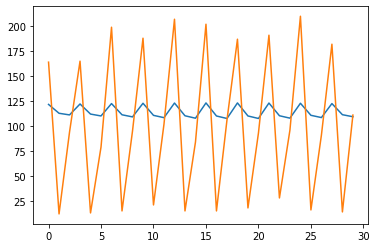

In [18]:
plt.plot([i for i in range(30)],list(y_pred[0])[0:30])
plt.plot([i for i in range(30)],list(y_val[0])[0:30])

## Entrenamiento con RandomForestRegresor

In [19]:
bosque =  RandomForestRegressor()
scores = cross_val_score(bosque, X_train, y_train, cv=5,scoring = 'neg_mean_squared_error')
print('R2 promedio:',np.mean(scores))
bosque = bosque.fit(X_train,y_train)
joblib.dump(bosque, 'bosque_mes.pkl',compress=9)

R2 promedio: -1326.4431222266007


['bosque_mes.pkl']

## Prediccion

In [20]:
y_pred = bosque.predict(X_train)
rmse(y_train, y_pred)

94.04680861111116

## Entrenamiento con tuneado de parametros

In [21]:
clf =  RandomForestRegressor()
tuned_params = { 
            #"criterion": ['entropy','gini'],
            "max_features": [1,2,4,8,16,32],
            "n_estimators" :[512,1024,2048,4096],
            "min_samples_split" : [2,4,8,16,32,64,128],
            "bootstrap" : [False,True],
            "max_features": ['auto','sqrt'],
            "max_depth": [2,4,8,16,32,64,128,256]
            }


clf = GridSearchCV(clf, tuned_params,cv=5,scoring='neg_mean_squared_error',n_jobs = -1)
clf.fit(X_train, y_train)
print("Mejores Parametros Encontrados")
print(clf.best_params_)

##
## Se entrena el clasificador
##
clf =  RandomForestRegressor(
    #criterion  = clf.best_params_['criterion'],
    max_features  = clf.best_params_['max_features'],
    n_estimators  = clf.best_params_['n_estimators'],
    min_samples_split  = clf.best_params_['min_samples_split'],
    bootstrap  = clf.best_params_['bootstrap'],
    max_depth  = clf.best_params_['max_depth'],
)


scores = cross_val_score(clf, X_train, y_train, cv=5,scoring = 'neg_mean_squared_error')
print('RMSE CV entrenamiento promedio:',np.mean(scores))

### Se guarda el Modelo

bosque = clf.fit(X_train,y_train)
joblib.dump(bosque, 'bosque_tuning_mes.pkl',compress=9)



y_pred = bosque.predict(X_train)
print("RMSE entrenamiento:",rmse(y_train, y_pred))

Mejores Parametros Encontrados
{'bootstrap': True, 'max_depth': 128, 'max_features': 'auto', 'min_samples_split': 16, 'n_estimators': 1024}
RMSE CV entrenamiento promedio: -1198.305688477314
RMSE entrenamiento: 546.5580975358841


## Prediccion para tuneado de datos

In [ ]:
y_pred = bosque.predict(X_val)
print("Error de validación:",rmse(y_val, y_pred))
y_val = pd.DataFrame(y_val)
y_pred = pd.DataFrame(y_pred)
plt.plot([i for i in range(30)],list(y_pred[1])[0:30])
plt.plot([i for i in range(30)],list(y_val[1])[0:30])

# Modelo predictivo por dia

In [ ]:
train_dia = train.groupby(['DIA','MES','ANIO','CLUSTER']).sum().reset_index()
train_dia = train_dia[['DIA','ESPECIAL','MES','ANIO','CLUSTER','atropello','caida_ocupante','choque','otro','volcamiento','incendio','choque_atropello']]

val_dia = val.groupby(['DIA','MES','ANIO','CLUSTER']).sum().reset_index()
val_dia = val_dia[['DIA','ESPECIAL','MES','ANIO','CLUSTER','atropello','caida_ocupante','choque','otro','volcamiento','incendio','choque_atropello']]


In [ ]:
X_train = train_dia[['DIA','MES','ANIO','CLUSTER','ESPECIAL']].values
y_train = train_dia[['DIA','ESPECIAL','atropello','caida_ocupante','choque','choque_atropello','incendio','otro','volcamiento']].values


In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler = min_max_scaler.fit(X_train)
X_train = min_max_scaler.transform(X_train)
joblib.dump(min_max_scaler,"scaler_dia.pkl")

In [ ]:
clf =  RandomForestRegressor()
tuned_params = { 
            #"criterion": ['entropy','gini'],
            "max_features": [1,2,4,8,16,32],
            "n_estimators" :[512,1024,2048,4096],
            "min_samples_split" : [2,4,8,16,32,64,128],
            "bootstrap" : [False,True],
            "max_features": ['auto','sqrt'],
            "max_depth": [2,4,8,16,32,64,128,256]
            }


clf = GridSearchCV(clf, tuned_params,cv=5,scoring='neg_mean_squared_error',n_jobs = -1)
clf.fit(X_train, y_train)
print("Mejores Parametros Encontrados")
print(clf.best_params_)

##
## Se entrena el clasificador
##
clf =  RandomForestRegressor(
    #criterion  = clf.best_params_['criterion'],
    max_features  = clf.best_params_['max_features'],
    n_estimators  = clf.best_params_['n_estimators'],
    min_samples_split  = clf.best_params_['min_samples_split'],
    bootstrap  = clf.best_params_['bootstrap'],
    max_depth  = clf.best_params_['max_depth'],
)

scores = cross_val_score(clf, X_train, y_train, cv=5,scoring = 'neg_mean_squared_error')
print('RMSE CV entrenamiento promedio:',np.mean(scores))

### Se guarda el Modelo

bosque = clf.fit(X_train,y_train)
joblib.dump(bosque, 'bosque_tuning_dia.pkl',compress=9)



y_pred = bosque.predict(X_train)
print("RMSE entrenamiento:",rmse(y_train, y_pred))

In [ ]:
y_pred = bosque.predict(X_val)
print("Error de validación:",rmse(y_val, y_pred))
y_val = pd.DataFrame(y_val)
y_pred = pd.DataFrame(y_pred)
#plt.plot([i for i in range(30)],list(y_pred[1])[0:30])
#plt.plot([i for i in range(30)],list(y_val[1])[0:30])
plt.plot(y_pred)
plt.plot(y_val)